# Introduction
The following is for the individual project for BST 270: Reproducible Data Science.  The first and the third figures from [Congress Today Is Older Than It's Ever Been](https://fivethirtyeight.com/features/aging-congress-boomers/) are reproduced below.  For both figures, only the static components were reproduced.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# First Figure
## Read and wrangle data
Very little wrangling of data is required in this step to make it appropriate to create the figure, as the age of each member is provided for each member.  Members that serve for multiple terms have their age recalculated for each subsequent session of congress, so there was no need to do this calculation here.

In [2]:
aging_congress = pd.read_csv("../data/data_aging_congress.csv",
                             parse_dates=['start_date'])

In [3]:
aging_congress = aging_congress.sort_values(by="congress")
aging_congress["chamber"] = pd.Categorical(aging_congress["chamber"], categories=["Senate", "House"], ordered=True)
congress_summary = aging_congress.groupby(['congress', 'chamber'], observed=True).agg(
    year=('start_date', lambda x: min(x).year),
    median_age=('age_years', 'median')).reset_index()

## Render Figure
The first figure in the article is a simple step figure.  The shape reproduced here appears to be identical to the original article.

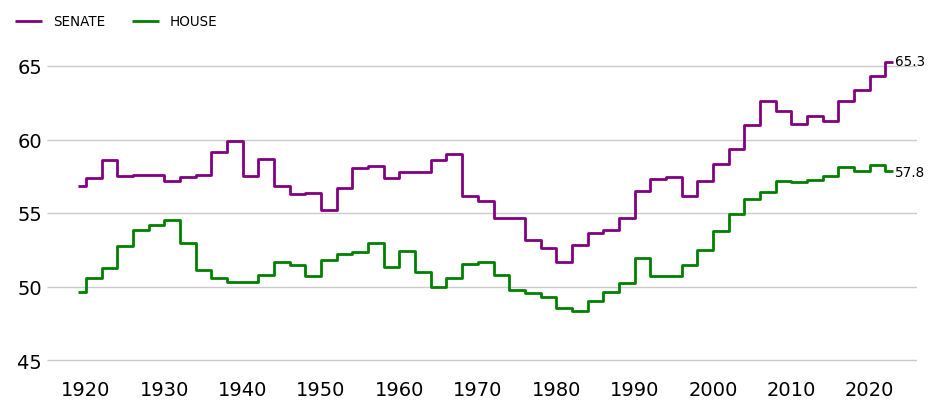

In [4]:
plt.style.use("fivethirtyeight")

# Split the data by chamber to create two separate lines
house_data = congress_summary[congress_summary['chamber'] == 'House']
senate_data = congress_summary[congress_summary['chamber'] == 'Senate']

# Get the age in the last year for the labels, rounded to 1 decimal place
house_age_final_year = round(house_data.iloc[-1]["median_age"], 1)
senate_age_final_year = round(senate_data.iloc[-1]["median_age"], 1)

# Create the figure
fig, ax = plt.subplots(figsize=(10, 4), facecolor='white')

# Two line graphs using step style, each for the Senate and the House.
ax.step(senate_data['year'], senate_data['median_age'], where='mid', label='SENATE', color='purple', linewidth=2)
ax.step(house_data['year'], house_data['median_age'], where='mid', label='HOUSE', color='green', linewidth=2)

# Add the age text labe on the right side of the graph
ax.text(2023.2, senate_age_final_year, str(senate_age_final_year), fontsize='x-small', verticalalignment="center", horizontalalignment="left")
ax.text(2023.2, house_age_final_year, str(house_age_final_year), fontsize='x-small', verticalalignment="center", horizontalalignment="left")

# X axis labeled every 10 years, without grid lines
plt.xlim(1915, 2026)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.grid(False)

# Y axis every 5 years, keeping the grid line 
plt.ylim(44, 66)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

# set the background to white
ax.set_facecolor('white')

# Remove the border
for spine in ax.spines.values():
    spine.set_visible(False)

# Set the legend across the top
ax.legend(title='', loc='upper left', bbox_to_anchor=(-0.05, 1.15), ncol=2, frameon=False, fontsize='x-small')

plt.show()

# Third Figure
## Wrangle Data
In order to recreate the plot, the number of members for each congress needed to be calculated, then the percentage that each generation represented for all included sessions of congress could be calculated.

In [5]:
# Summarize Number of members in each generation for each congress
generation_summary = aging_congress.groupby(['congress', 'generation']).agg(
    count=('generation', 'size'),
    year=('start_date', lambda x: min(x).year),
).reset_index()

# Find the total number of members in each congress
generation_summary['congress_member_total'] = generation_summary.groupby('congress')['count'].transform('sum')

# Determine the percent for each generation
generation_summary['percent'] = 100 * generation_summary['count'] / generation_summary['congress_member_total']

# Pivot the DataFrame to get generations as columns
generation_summary_pivoted = generation_summary.pivot(index='year', columns='generation', values='percent').fillna(0)

## Render Figure
The figure reproduced below appears have the same shape as the one from the article, so there does not appear to be any additional manipulation performed by fivethirtyeight in order to produce their figure.

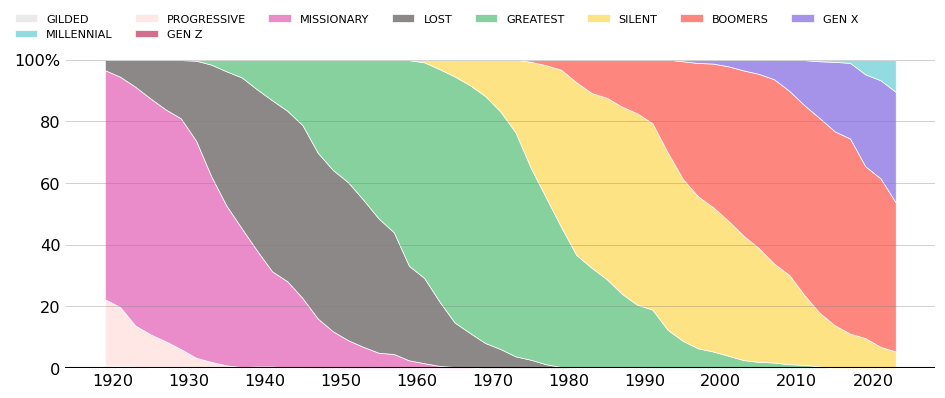

In [6]:
# Use fivethrityeight style
plt.style.use("fivethirtyeight")

# Generation ordering and colors based on the 538 article
generations = ["Gilded", "Progressive", "Missionary", "Lost", "Greatest", 
                       "Silent", "Boomers", "Gen X", "Millennial", "Gen Z"]
colors = ['#e9e9e9','#ffe7e6','#ea8cca','#8b8887','#86d19d','#fde384','#fd877e',
          '#a593ea','#92dce1','#d26e8c']

# Plotting
fig, ax = plt.subplots(figsize=(10, 4), facecolor='white')

# Create stacked area plot
ax.stackplot(generation_summary_pivoted.index, [generation_summary_pivoted[generation] for generation in generations],
             labels=[generation.upper() for generation in generations],
             colors=colors, edgecolor='white', alpha=1)


# Set the x axis to every decade
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.grid(False)
x_ticks = list(range(1920, 2021, 10))
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, fontsize='small')

# Set y labels and add % to just 100
y_ticks = list(range(0, 101, 20))
y_labels = ['100%' if val == 100 else str(int(val)) for val in y_ticks]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels, fontsize='small')

# Make the grid lines visible over the stackplot
ax.set_axisbelow(False)
ax.yaxis.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)


# Black line at 0 percent
ax.axhline(y=0, color='black', linewidth=1.5)

# set the background to white
ax.set_facecolor('white')

# Remove the border
for spine in ax.spines.values():
    spine.set_visible(False)

# Add Legend; Reorder because matplotlib orders by column instead of by row
reorder = lambda x, num_cols: sum((x[i::num_cols] for i in range(num_cols)), [])
handles, labels = ax.get_legend_handles_labels()
ax.legend(reorder(handles, 8), reorder(labels, 8), title='', loc='upper left', bbox_to_anchor=(-0.07, 1.125), ncol=8, frameon=False, fontsize='xx-small')

# Show the plot
plt.show()